# Deep Learning Applications: Laboratory #1

In this first laboratory we will work relatively simple architectures to get a feel for working with Deep Models. This notebook is designed to work with PyTorch, but as I said in the introductory lecture: please feel free to use and experiment with whatever tools you like.


## Exercise 1: Warming Up

In this series of exercises I want you to try to duplicate (on a small scale) the results of the ResNet paper:

> [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385), Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun, CVPR 2016.

We will do this in steps using a Multilayer Perceptron on MNIST.

Recall that the main message of the ResNet paper is that **deeper** networks do not **guarantee** more reduction in training loss (or in validation accuracy). Below you will incrementally build a sequence of experiments to verify this for an MLP. A few guidelines:

- I have provided some **starter** code at the beginning. **NONE** of this code should survive in your solutions. Not only is it **very** badly written, it is also written in my functional style that also obfuscates what it's doing (in part to **discourage** your reuse!). It's just to get you _started_.
- These exercises ask you to compare **multiple** training runs, so it is **really** important that you factor this into your **pipeline**. Using [Tensorboard](https://pytorch.org/tutorials/recipes/recipes/tensorboard_with_pytorch.html) is a **very** good idea -- or, even better [Weights and Biases](https://wandb.ai/site).
- You may work and submit your solutions in **groups of at most two**. Share your ideas with everyone, but the solutions you submit _must be your own_.

First some boilerplate to get you started, then on to the actual exercises!


### Preface: Some code to get you started

What follows is some **very simple** code for training an MLP on MNIST. The point of this code is to get you up and running (and to verify that your Python environment has all needed dependencies).

**Note**: As you read through my code and execute it, this would be a good time to think about _abstracting_ **your** model definition, and training and evaluation pipelines in order to make it easier to compare performance of different models.


# Installation

To get you started, you should be able to recreate an Anaconda environment suitable for this lab using:

#### conda create -n Lab1_DLA -c conda-forge jupyterlab ipython matplotlib scikit-learn tqdm pytorch torchvision tensorboard

and then activate it and fire up the notebook with:

#### jupyter lab Lab1-CNNs.ipynb

### aggiungi tutti i pacchetti necessari guardando gli import


Cosa mi piacerebbe variare

- dataset (cifar10, mnist)
- splitting del dataset
- preprocessing del dataset (normalizzazione, data augmentation)
- architettura (mlp, cnn, cnnres)
- iperparametri dell'architettura (width, depth, n° parametri modello)
- iperparametri del training loop (epoche, batchs_ize, lr)
- ottimizzatore
- iperparametri dell'ottimizzatore
- device (capire i tempi)

scegli il learning rate come dice karpathy


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim.lr_scheduler as lr_scheduler

from torchvision.datasets import MNIST, CIFAR10
import torchvision.transforms as transforms
from torch.utils.data import Subset

import numpy as np
import matplotlib.pyplot as plt

from functools import reduce

from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report

import wandb
import PIL
import os
import torchviz
from torchviz import make_dot
from torchview import draw_graph
from sklearn.metrics import confusion_matrix
from collections import Counter

from functools import reduce
import math

## Device


In [2]:
if torch.cuda.is_available():
    i = 1
    device = torch.device("cuda:" + str(i))  # cuda:0 , cuda:1
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"device: {device}")
print(
    "GPU: " + torch.cuda.get_device_name(i)
    if device == torch.device("cuda:" + str(i))
    else ""
)

device: cuda:1
GPU: NVIDIA RTX A2000 12GB


## Dataset, Architetture e Ottimizzatore


In [3]:
data = {
    "cifar10": {
        "name": "cifar10",
        "example_shape": (3, 32, 32),
        "num_classes": 10,
    },
    "mnist": {
        "name": "mnist",
        "example_shape": (1, 28, 28),
        "num_classes": 10,
    },
}

architectures = {
    "MLP": {"name": "MLP"},
    "MyCNN": {"name": "MyCNN"},
    "VGG": {"name": "VGG"},
    "ResNet": {"name": "ResNet"},
    "PlainNetwork": {"name": "PlainNetwork"},
    "CustomCNN": {"name": "CustomCNN"},
}
optimizers = {"sgd": {"name": "sgd"}, "adam": {"name": "adam"}}

# Setting Experiments


In [4]:
# Hyperparameters

dataset = data["cifar10"]
architecture = architectures["CustomCNN"]
opt = optimizers["sgd"]

batch_size = 64
val_size = 10000
epochs = 10
lr = 0.1

# Hyperparameters of single architecture below

In [5]:
input_size = result = reduce(
    lambda a, b: a * b, dataset["example_shape"]
)  # i.e. 3*32*32
batch_shape = (batch_size,) + dataset["example_shape"]  # ex. (64,1,28,28)

print(f"Input size: {input_size}")
print(f"batch_shape: {batch_shape}")

Input size: 3072
batch_shape: (64, 3, 32, 32)


## Setting WANDB


In [6]:
%env "WANDB_NOTEBOOK_NAME" "Vittorio Casula_Lab 1"

wandb.init(
    project="Lab1_DLA",
    config={
        "dataset": dataset["name"],
        "architecture": architecture["name"],
        "initial_lr": lr,
        "epochs": epochs,
        "batch size" : batch_size,
    }
)

env: "WANDB_NOTEBOOK_NAME"="Vittorio Casula_Lab 1"


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: vittoriocasula (team-vittoriocasula). Use `wandb login --relogin` to force relogin


#### Data preparation

Here is some basic dataset loading, validation splitting code to get you started working with MNIST.


In [7]:
# plot MNIST dataset distribution
def plot_hist_labels_distribution(data, num_classes, split, position):
    if split == "train":
        all_labels = torch.tensor(
            [tensor.item() for tensor in list(Counter(data.dataset.targets).keys())]
        ).float()
        title = "Training Set Label Distribution"
    elif split == "val":
        labels_val = [y for _, y in data]
        all_labels = torch.tensor([value for value in list(labels_val)]).float()
        title = "Validation Set Label Distribution"
    elif split == "test":
        all_labels = torch.tensor(
            [tensor.item() for tensor in list(Counter(data.targets).keys())]
        ).float()
        title = "Test Set Label Distribution"

    hist = torch.histc(all_labels, bins=num_classes)
    plt.subplot(1, 3, position)
    plt.bar(range(num_classes), hist, align="center")
    plt.xlabel("Labels")
    plt.ylabel("Number of Examples")
    plt.xticks(np.arange(0, num_classes, 1))
    plt.title(title)


def plot_hist_labels_distribution_string(data, num_classes, split, position):
    if split == "train":
        # all_labels = torch.tensor([value for value in list(data.dataset.targets)]).float()
        labels_train = [y for _, y in data]
        all_labels = torch.tensor([value for value in list(labels_train)]).float()
        classes = data.dataset.classes
        title = "Training Set Label Distribution"
    elif split == "val":
        labels_val = [y for _, y in data]
        all_labels = torch.tensor([value for value in list(labels_val)]).float()
        classes = data.dataset.classes
        title = "Validation Set Label Distribution"
    elif split == "test":
        all_labels = torch.tensor([value for value in list(data.targets)]).float()
        classes = data.classes
        title = "Test Set Label Distribution"

    hist = torch.histc(all_labels, bins=num_classes)
    plt.subplot(1, 3, position)
    plt.bar(range(num_classes), hist, align="center")
    plt.xlabel("Labels")
    plt.ylabel("Number of Examples")
    plt.xticks(np.arange(0, num_classes, 1), classes, rotation=90)
    plt.title(title)


# for mnist: get_normalize_values(ds_train_initial.data.float())
# for cifar10: get_normalize_values(ds_train_initial.data)


def get_normalize_values(data):
    return (
        data.mean(axis=(0, 1, 2)) / 255,
        data.std(axis=(0, 1, 2)) / 255,
    )

Files already downloaded and verified
Files already downloaded and verified
Classes: {'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}
N° samples train: 40000
N° samples validation: 10000
N° samples test: 10000


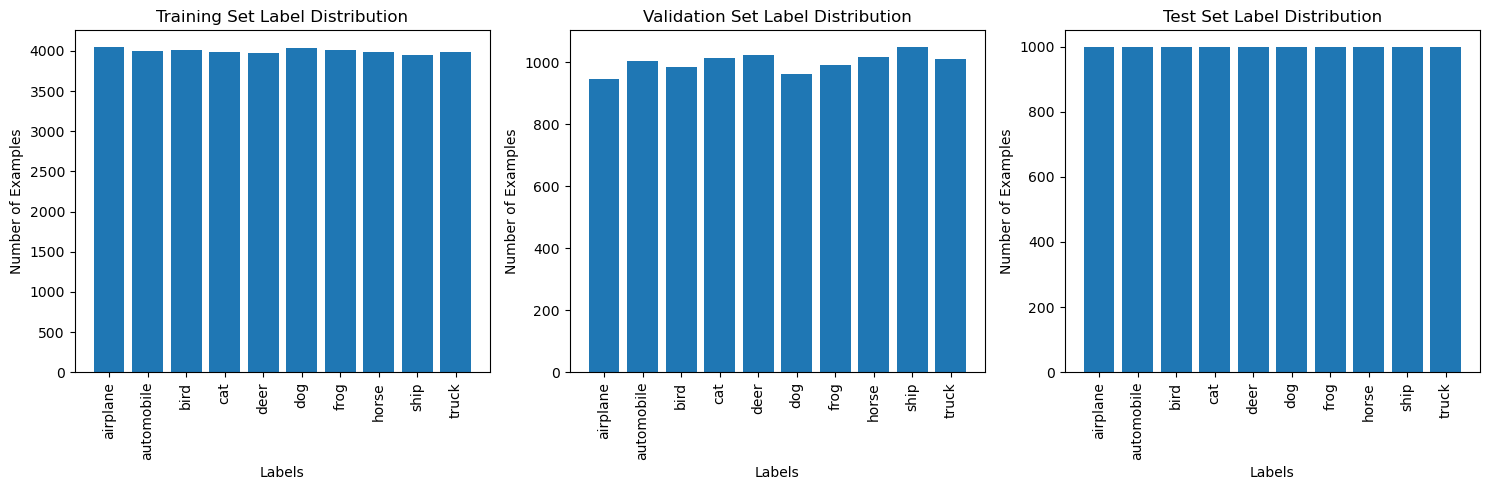

In [8]:
match dataset["name"]:
    case "mnist":
        transform = transforms.Compose(
            [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
        )

        ds_train_initial = MNIST(
            root="../dataset/", train=True, download=True, transform=transform
        )
        ds_test = MNIST(
            root="../dataset/", train=False, download=True, transform=transform
        )

        n_examples_test = len(ds_test)
        I = np.random.permutation(len(ds_train_initial))
        ds_val = Subset(ds_train_initial, I[:val_size])
        n_examples_val = len(ds_val)

        ds_train = Subset(ds_train_initial, I[val_size:])
        n_examples_train = len(ds_train)

        print(f"N° samples train: {n_examples_train}")
        print(f"N° samples validation: {n_examples_val}")
        print(f"N° samples test: {n_examples_test}")

        plt.figure(
            figsize=(15, 5)
        )  # Imposta la dimensione della figura per contenere i 3 grafici in riga
        plot_hist_labels_distribution(ds_train, dataset["num_classes"], "train", 1)
        plot_hist_labels_distribution(ds_val, dataset["num_classes"], "val", 2)
        plot_hist_labels_distribution(ds_test, dataset["num_classes"], "test", 3)
        plt.tight_layout()  # Ottimizza lo spaziamento tra i grafici
        plt.show()

    case "cifar10":
        transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize(
                    (0.49139968, 0.48215841, 0.44653091),
                    (0.24703223, 0.24348513, 0.26158784),
                ),
            ]
        )

        ds_train_initial = CIFAR10(
            root="../dataset/", train=True, download=True, transform=transform
        )

        ds_test = CIFAR10(
            root="../dataset/", train=False, download=True, transform=transform
        )

        n_examples_test = len(ds_test)

        print(f"Classes: {ds_train_initial.class_to_idx}")

        I = np.random.permutation(len(ds_train_initial))
        ds_val = Subset(ds_train_initial, I[:val_size])
        n_examples_val = len(ds_val)

        ds_train = Subset(ds_train_initial, I[val_size:])
        n_examples_train = len(ds_train)

        print(f"N° samples train: {n_examples_train}")
        print(f"N° samples validation: {n_examples_val}")
        print(f"N° samples test: {n_examples_test}")

        plt.figure(
            figsize=(15, 5)
        )  # Imposta la dimensione della figura per contenere i 3 grafici in riga

        plot_hist_labels_distribution_string(
            ds_train, dataset["num_classes"], "train", 1
        )
        plot_hist_labels_distribution_string(ds_val, dataset["num_classes"], "val", 2)
        plot_hist_labels_distribution_string(ds_test, dataset["num_classes"], "test", 3)

        plt.tight_layout()  # Ottimizza lo spaziamento tra i grafici
        plt.show()

## Dataloaders


In [9]:
def get_image_array(dataloader):
    first_batch = (next(iter(dataloader))[0]).numpy()
    list_batch = np.split(first_batch, len(first_batch))
    if list_batch[0].shape[1] == 1:  # single channels images
        image_array = np.array(
            [el.squeeze() for el in list_batch]
        )  # TODO risolvere con immagini a più canali
        images = [
            PIL.Image.fromarray((image * 255).astype(np.uint8)) for image in image_array
        ]
    else:  # multiple channels images
        image_array = np.array([el.squeeze().transpose(1, 2, 0) for el in list_batch])
        images = [
            PIL.Image.fromarray((image * 255).astype("uint8"), "RGB")
            for image in image_array
        ]
    return images


# dataloaders

dl_train = torch.utils.data.DataLoader(
    ds_train, batch_size, shuffle=True, num_workers=4
)
dl_val = torch.utils.data.DataLoader(ds_val, batch_size, num_workers=4)
dl_test = torch.utils.data.DataLoader(ds_test, batch_size, shuffle=False, num_workers=4)

num_batch_train = len(dl_train)
num_batch_val = len(dl_val)
num_batch_test = len(dl_test)

print(f"N° batches train: {num_batch_train}")
print(f"N° batches val: {num_batch_val}")
print(f"N° batches test: {num_batch_test}")

# visualize in wandb a batch of images
batch_image_train = get_image_array(dl_train)
batch_image_val = get_image_array(dl_val)
batch_image_test = get_image_array(dl_test)

wandb.log(
    {
        "examples train": [wandb.Image(image) for image in batch_image_train],
        "examples val": [wandb.Image(image) for image in batch_image_val],
        "examples test": [wandb.Image(image) for image in batch_image_test],
    }
)

N° batches train: 625
N° batches val: 157
N° batches test: 157


#### Boilerplate training and evaluation code

This is some **very** rough training, evaluation, and plotting code. Again, just to get you started. I will be _very_ disappointed if any of this code makes it into your final submission.


In [10]:
# Function to train a model for a single epoch over the data loader.
def train_epoch(model, dl, opt, epoch, device):
    model.train()
    losses = []

    for xs, ys in tqdm(dl, desc=f"Training epoch {epoch}", leave=True, position=0):
        xs = xs.to(device)
        ys = ys.to(device)
        opt.zero_grad()
        logits = model(xs)
        loss = F.cross_entropy(logits, ys)
        loss.backward()

        opt.step()

        losses.append(loss.item())
    return losses


def evaluate_model(model, dl, device, split_name=""):
    model.eval()
    predictions = []
    gts = []
    losses = []
    with torch.no_grad():
        for xs, ys in tqdm(
            dl, desc="\tEvaluating on " + split_name, leave=True, position=0
        ):
            xs = xs.to(device)
            ys = ys.to(device)
            logits = model(xs)
            preds = torch.argmax(logits, dim=1)
            loss = F.cross_entropy(logits, ys)

            # accumulate values
            losses.append(loss.item())
            gts.append(ys.detach().cpu().numpy())
            predictions.append(preds.detach().cpu().numpy())
    return gts, predictions, losses

## Architectures


In [11]:
# input_shape = (h_in,w_in)
# kernel_size, padding, stride, dilation :all tuple variable


def get_output_size(h_in, w_in, kernel_size, padding, stride, dilation):
    h_out = math.floor(
        (h_in + 2 * padding[0] - dilation[0] * (kernel_size[0] - 1) - 1) / (stride[0])
        + 1
    )
    w_out = math.floor(
        (w_in + 2 * padding[1] - dilation[1] * (kernel_size[1] - 1) - 1) / (stride[1])
        + 1
    )
    return h_out, w_out


c_in = 3
c_out = 6

h_in = 32
w_in = 32
input_shape = (c_in, h_in, w_in)

padding = (0, 0)
dilation = (1, 1)
kernel_size = (5, 5)
stride = (1, 1)
h_out, w_out = get_output_size(h_in, w_in, kernel_size, padding, stride, dilation)
# print(c_out, h_out, w_out)

In [12]:
class MLP(nn.Module):
    def __init__(self, input_size, width, depth, output_size):
        super().__init__()

        self.input_layer = nn.Linear(input_size, width)
        self.hidden_layers = nn.ModuleList(
            [nn.Linear(width, width) for _ in range(depth)]
        )
        self.output_layer = nn.Linear(width, output_size)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        out = self.input_layer(x)
        out = torch.relu(out)

        # insert ReLU between each Linear layer
        for layer in self.hidden_layers:
            out = layer(out)
            out = torch.relu(out)

        out = self.output_layer(out)
        return out

In [13]:
class MyCNN(nn.Module):
    def __init__(self, input_channels, output_size, depth, channels_intermediate):
        super().__init__()

        self.output_size = output_size
        self.depth = depth
        self.channels_intermediate = channels_intermediate

        self.kernel_size = (5, 5)
        self.kernel_size_pool = (2, 2)

        self.first_conv = nn.Sequential(
            nn.Conv2d(
                in_channels=input_channels,
                out_channels=self.channels_intermediate,
                kernel_size=self.kernel_size,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=self.kernel_size_pool),
        )

        self.intermediate_block = nn.ModuleList()
        for _ in range(self.depth):
            self.intermediate_block.append(
                nn.Conv2d(
                    in_channels=self.channels_intermediate,
                    out_channels=self.channels_intermediate,
                    kernel_size=self.kernel_size,
                )
            )
            self.intermediate_block.append(nn.ReLU())
            self.intermediate_block.append(
                nn.MaxPool2d(kernel_size=self.kernel_size_pool)
            )

    def forward(self, x):
        out = self.first_conv(x)

        for layer in self.intermediate_block:
            out = layer(out)

        self.input_fcs = reduce(lambda a, b: a * b, out.shape[1:])

        self.fc1 = nn.Linear(self.input_fcs, 300).to(device)
        self.fc2 = nn.Linear(300, 100).to(device)
        self.fc3 = nn.Linear(100, self.output_size).to(device)

        out = out.flatten(1)
        out = self.fc1(out)
        out = torch.relu(out)
        out = self.fc2(out)
        out = torch.relu(out)
        out = self.fc3(out)
        return out


"""
x = torch.randn(64,3,32,32).to(device)
m = MyCNN(input_channels= x.shape[1], output_size= 10, depth=2, channels_intermediate=20).to(device)
res = m(x)
print(res.shape)
"""
pass

In [14]:
VGG_types = {
    "VGG11": [64, "M", 128, "M", 256, 256, "M", 512, 512, "M", 512, 512, "M"],
    "VGG13": [
        64,
        64,
        "M",
        128,
        128,
        "M",
        256,
        256,
        "M",
        512,
        512,
        "M",
        512,
        512,
        "M",
    ],
    "VGG16": [
        64,
        64,
        "M",
        128,
        128,
        "M",
        256,
        256,
        256,
        "M",
        512,
        512,
        512,
        "M",
        512,
        512,
        512,
        "M",
    ],
    "VGG19": [
        64,
        64,
        "M",
        128,
        128,
        "M",
        256,
        256,
        256,
        256,
        "M",
        512,
        512,
        512,
        512,
        "M",
        512,
        512,
        512,
        512,
        "M",
    ],
}


class VGG(nn.Module):
    def __init__(
        self,
        architecture,
        in_channels=3,
        in_height=224,
        in_width=224,
        num_hidden=4096,
        num_classes=10,
    ):
        super(VGG, self).__init__()
        self.in_channels = in_channels
        self.in_width = in_width
        self.in_height = in_height
        self.num_hidden = num_hidden
        self.num_classes = num_classes
        self.convs = self.init_convs(architecture)
        self.fcs = self.init_fcs(architecture)

    def forward(self, x):
        x = self.convs(x)
        # print(x.shape)  # torch.Size([64, 512, 1, 1])
        x = x.reshape(x.size(0), -1)
        # print(x.shape) #torch.Size([64, 512])
        x = self.fcs(x)
        return x

    def init_fcs(self, architecture):
        pool_count = architecture.count("M")

        factor = 2**pool_count

        if (self.in_height % factor) + (self.in_width % factor) != 0:
            raise ValueError(
                f"`in_height` and `in_width` must be multiples of {factor}"
            )
        out_height = self.in_height // factor
        out_width = self.in_width // factor

        last_out_channels = next(x for x in architecture[::-1] if type(x) == int)
        return nn.Sequential(
            nn.Linear(last_out_channels * out_height * out_width, self.num_hidden),
            nn.ReLU(),
            # nn.Dropout(p=0.5),
            nn.Linear(self.num_hidden, self.num_hidden),
            nn.ReLU(),
            # nn.Dropout(p=0.5),
            nn.Linear(self.num_hidden, self.num_classes),
        )

    def init_convs(self, architecture):
        layers = []
        in_channels = self.in_channels

        for x in architecture:
            if type(x) == int:
                out_channels = x
                layers.extend(
                    [
                        nn.Conv2d(
                            in_channels=in_channels,
                            out_channels=out_channels,
                            kernel_size=(3, 3),
                            stride=(1, 1),
                            padding=(1, 1),
                        ),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU(),
                    ]
                )
                in_channels = x
            else:
                layers.append(nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)))
        return nn.Sequential(*layers)


"""
x = torch.randn(64, 3, 32, 32).to(device)
m = VGG(
    in_channels=3,
    in_height=32,
    in_width=32,
    num_hidden=512,
    architecture=VGG_types["VGG11"],
).to(device)
res = m(x)
"""
pass

![nets](./img/nets.png)


In [15]:
# CNN no residuals
class SequentialBlock(nn.Module):
    def __init__(self, num_layers, in_channels, out_channels, stride=1):
        super(SequentialBlock, self).__init__()
        self.num_layers = num_layers

        self.stack = nn.Sequential(
            nn.Conv2d(
                in_channels, out_channels, kernel_size=3, stride=stride, padding=1
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.stack(x)


class PlainNetwork(nn.Module):
    def __init__(self, num_layers, block, image_channels, num_classes):
        super(PlainNetwork, self).__init__()

        if num_layers == 18:
            layers = [2, 2, 2, 2]
        elif num_layers == 34 or num_layers == 50:
            layers = [3, 4, 6, 3]

        self.in_channels = 64

        self.first_layers = nn.Sequential(
            nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        )

        self.layer1 = self.make_layers(
            num_layers, block, layers[0], intermediate_channels=64, stride=1
        )
        self.layer2 = self.make_layers(
            num_layers, block, layers[1], intermediate_channels=128, stride=2
        )
        self.layer3 = self.make_layers(
            num_layers, block, layers[2], intermediate_channels=256, stride=2
        )
        self.layer4 = self.make_layers(
            num_layers, block, layers[3], intermediate_channels=512, stride=2
        )

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.first_layers(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        return x

    def make_layers(
        self, num_layers, block, num_residual_blocks, intermediate_channels, stride
    ):
        layers = []

        layers.append(
            block(num_layers, self.in_channels, intermediate_channels, stride)
        )
        self.in_channels = intermediate_channels
        for _ in range(num_residual_blocks - 1):
            layers.append(block(num_layers, self.in_channels, intermediate_channels))
        return nn.Sequential(*layers)


def CNN18NoResidual(img_channels=batch_shape[1], num_classes=dataset["num_classes"]):
    return PlainNetwork(18, SequentialBlock, img_channels, num_classes)


def CNN34NoResidual(img_channels=batch_shape[1], num_classes=dataset["num_classes"]):
    return PlainNetwork(34, SequentialBlock, img_channels, num_classes)


def CNN50NoResidual(img_channels=batch_shape[1], num_classes=dataset["num_classes"]):
    return PlainNetwork(50, SequentialBlock, img_channels, num_classes)


def compute_cam(self, x, class_label):
    x = x.to(device)
    self.eval()
    class_weight = (list(self.parameters())[-2]).data
    # class_weight.shape --> torch.Size([10, 128]) # sono i pesi che sono collegati al neurone dell'ultimo layer corrispondente alla classe scelta
    channels = class_weight.shape[
        1
    ]  # numero di canali dell'ultimo layer convoluzionale (canali della feature map)
    layers = list(self.modules())

    index_avg_poll = 0
    for i, layer in enumerate(layers):
        if isinstance(layer, nn.AvgPool2d) or isinstance(layer, nn.AdaptiveAvgPool2d):
            index_avg_poll = i

    with torch.no_grad():
        detectors = list(self.modules())[1 : -(len(layers) - index_avg_poll)]

        act_map = reduce(
            lambda x, f: f(x), detectors, x
        )  # act_map.shape --> torch.Size([64, 128, 4, 4])

    weights = class_weight[
        class_label
    ]  # torch.Size([128]) ricavo i pesi relativi al neurone class_label
    weights = weights.view(-1, channels, 1, 1)  # (1, 128, 1, 1)
    cam = act_map * weights  # (64, 128, 4, 4) * (1, 128, 1, 1) = (64, 128, 4, 4)
    cam = F.relu(cam.sum(dim=1, keepdim=True))  # (64, 1, 4, 4)
    return cam


"""
x = torch.randn(64, 3, 32, 32).to(device)
model = CNN34NoResidual(3, 10).to(device)
res = model(x)
print(res.shape)"""
pass

In [16]:
class BlockResidual(nn.Module):
    def __init__(
        self, num_layers, in_channels, out_channels, identity_downsample=None, stride=1
    ):
        super(BlockResidual, self).__init__()
        self.num_layers = num_layers

        self.conv1 = nn.Conv2d(
            in_channels, out_channels, kernel_size=3, stride=stride, padding=1
        )
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(
            out_channels, out_channels, kernel_size=1, stride=1, padding=0
        )
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample

    def forward(self, x):
        identity = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)
        x += identity
        x = self.relu(x)
        return x


class ResNet(nn.Module):
    def __init__(self, num_layers, block, image_channels, num_classes):
        super(ResNet, self).__init__()

        if num_layers == 18:
            layers = [2, 2, 2, 2]
        elif num_layers == 34 or num_layers == 50:
            layers = [3, 4, 6, 3]

        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # ResNetLayers
        self.layer1 = self.make_layers(
            num_layers, block, layers[0], intermediate_channels=64, stride=1
        )
        self.layer2 = self.make_layers(
            num_layers, block, layers[1], intermediate_channels=128, stride=2
        )
        self.layer3 = self.make_layers(
            num_layers, block, layers[2], intermediate_channels=256, stride=2
        )
        self.layer4 = self.make_layers(
            num_layers, block, layers[3], intermediate_channels=512, stride=2
        )

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        return x

    def make_layers(
        self, num_layers, block, num_residual_blocks, intermediate_channels, stride
    ):
        layers = []
        identity_downsample = nn.Sequential(
            nn.Conv2d(
                self.in_channels, intermediate_channels, kernel_size=1, stride=stride
            ),
            nn.BatchNorm2d(intermediate_channels),
        )

        layers.append(
            block(
                num_layers,
                self.in_channels,
                intermediate_channels,
                identity_downsample,
                stride,
            )
        )
        self.in_channels = intermediate_channels
        for _ in range(num_residual_blocks - 1):
            layers.append(block(num_layers, self.in_channels, intermediate_channels))
        return nn.Sequential(*layers)


def ResNet18(img_channels=batch_shape[1], num_classes=dataset["num_classes"]):
    return ResNet(18, BlockResidual, img_channels, num_classes)


def ResNet34(img_channels=batch_shape[1], num_classes=dataset["num_classes"]):
    return ResNet(34, BlockResidual, img_channels, num_classes)


def ResNet50(img_channels=batch_shape[1], num_classes=dataset["num_classes"]):
    return ResNet(50, BlockResidual, img_channels, num_classes)


"""
x = torch.randn(64, 3, 32, 32).to(device)
model = ResNet34(3, 10).to(device)
res = model(x)
print(res.shape)
"""
pass

In [17]:
import torch.nn as nn


class CustomModel(nn.Module):
    def __init__(self, input_channels, output_size):
        super(CustomModel, self).__init__()

        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=3, padding=1)
        self.norm1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.norm2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.norm3 = nn.BatchNorm2d(64)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2)

        self.avg_pool = nn.AdaptiveAvgPool2d(1)  # Adaptive AvgPooling to any input size

        self.fc = nn.Linear(64, output_size)

    def forward(self, x):
        x = self.conv1(x)
        x = self.norm1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.norm2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.norm3(x)
        x = self.relu3(x)
        x = self.pool3(x)

        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

    def compute_cam(self, x, class_label):
        x = x.to(device)
        self.eval()
        class_weight = (list(self.parameters())[-2]).data
        # class_weight.shape --> torch.Size([10, 128]) # sono i pesi che sono collegati al neurone dell'ultimo layer corrispondente alla classe scelta
        channels = class_weight.shape[
            1
        ]  # numero di canali dell'ultimo layer convoluzionale (canali della feature map)
        layers = list(self.modules())

        index_avg_poll = 0
        for i, layer in enumerate(layers):
            if isinstance(layer, nn.AvgPool2d) or isinstance(
                layer, nn.AdaptiveAvgPool2d
            ):
                index_avg_poll = i

        with torch.no_grad():
            detectors = list(self.modules())[1 : -(len(layers) - index_avg_poll)]

            act_map = reduce(
                lambda x, f: f(x), detectors, x
            )  # act_map.shape --> torch.Size([64, 128, 4, 4])

        weights = class_weight[
            class_label
        ]  # torch.Size([128]) ricavo i pesi relativi al neurone class_label
        weights = weights.view(-1, channels, 1, 1)  # (1, 128, 1, 1)
        cam = act_map * weights  # (64, 128, 4, 4) * (1, 128, 1, 1) = (64, 128, 4, 4)
        cam = F.relu(cam.sum(dim=1, keepdim=True))  # (64, 1, 4, 4)
        return cam


"""
class CustomModel(nn.Module):
    def __init__(self, input_channels, output_size):
        super(CustomModel, self).__init__()

        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=5, padding=3)
        self.norm1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.norm2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.norm3 = nn.BatchNorm2d(64)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2)

        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.norm4 = nn.BatchNorm2d(128)
        self.relu4 = nn.ReLU()
        self.pool4 = nn.AvgPool2d(kernel_size=4)  # avarage pooling

        self.flatten = nn.Flatten()
        self.fc = nn.Linear(128, output_size)

    def forward(self, x):
        # print("Batch of images:", x.shape)
        x = self.conv1(x)
        # print("Shape after conv1:", x.shape)
        x = self.norm1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        # print("Shape after pool1:", x.shape)
        x = self.conv2(x)
        # print("Shape after conv2:", x.shape)
        x = self.norm2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        # print("Shape after pool2:", x.shape)
        x = self.conv3(x)
        # print("Shape after conv3:", x.shape)
        x = self.norm3(x)
        x = self.relu3(x)
        x = self.pool3(x)
        # print("Shape after pool3:", x.shape)
        x = self.conv4(x)
        # print("Shape after conv4:", x.shape)
        x = self.norm4(x)
        x = self.relu4(x)
        x = self.pool4(x)
        # print("Shape after pool4(avg pooling):", x.shape)
        x = self.flatten(x)
        # print("Shape after flatten:", x.shape)
        x = self.fc(x)
        # print("Shape after fc:", x.shape)
        return x
"""

'\nclass CustomModel(nn.Module):\n    def __init__(self, input_channels, output_size):\n        super(CustomModel, self).__init__()\n\n        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=5, padding=3)\n        self.norm1 = nn.BatchNorm2d(32)\n        self.relu1 = nn.ReLU()\n        self.pool1 = nn.MaxPool2d(kernel_size=2)\n\n        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)\n        self.norm2 = nn.BatchNorm2d(64)\n        self.relu2 = nn.ReLU()\n        self.pool2 = nn.MaxPool2d(kernel_size=2)\n\n        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)\n        self.norm3 = nn.BatchNorm2d(64)\n        self.relu3 = nn.ReLU()\n        self.pool3 = nn.MaxPool2d(kernel_size=2)\n\n        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1)\n        self.norm4 = nn.BatchNorm2d(128)\n        self.relu4 = nn.ReLU()\n        self.pool4 = nn.AvgPool2d(kernel_size=4)  # avarage pooling\n\n        self.flatten = nn.Flatten()\n        self.fc = nn.Linear(128

#### A _very_ minimal training pipeline.

Here is some basic training and evaluation code to get you started.

**Important**: I cannot stress enough that this is a **terrible** example of how to implement a training pipeline. You can do better!


In [18]:
match architecture["name"]:
    case "MLP":
        model = MLP(input_size, width=128, depth=4, output_size=dataset["num_classes"])
    case "CNN":
        model = MyCNN(
            input_channels=batch_shape[1],
            output_size=dataset["num_classes"],
            depth=1,
            channels_intermediate=32,
        )
    case "VGG":
        type_vgg = "VGG19"  # "VGG11", "VGG13", "VGG16", "VGG19"
        model = VGG(
            in_channels=batch_shape[1],
            in_height=batch_shape[2],
            in_width=batch_shape[3],
            architecture=VGG_types[type_vgg],
        )
    case "PlainNetwork":
        # model = CNN18NoResidual(batch_shape[1],dataset["num_classes"])
        model = CNN34NoResidual(batch_shape[1], dataset["num_classes"])
        # model = CNN50NoResidual(batch_shape[1],dataset["num_classes"])
    case "ResNet":
        # model = ResNet18(batch_shape[1],dataset["num_classes"])
        model = ResNet34(batch_shape[1], dataset["num_classes"])
        # model = ResNet50(batch_shape[1],dataset["num_classes"])
    case "CustomCNN":
        model = CustomModel(
            input_channels=batch_shape[1], output_size=dataset["num_classes"]
        )

model = model.to(device)

print(f'Architecture name: {architecture["name"]}')
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(f"N° of parameters: {params}")

Architecture name: CustomCNN
N° of parameters: 57290


In [19]:
match opt["name"]:
    case "adam":
        opt = torch.optim.Adam(params=model.parameters(), lr=lr)
    case "sgd":
        opt = torch.optim.SGD(params=model.parameters(), lr=lr)

sched = lr_scheduler.ReduceLROnPlateau(optimizer=opt, mode="min", patience=5)

## Grafo computazionale


In [20]:
# input_tensor = torch.randn(batch_shape).to(device)
# out = model(input_tensor)

# graph = make_dot(out, params=dict(model.named_parameters()), show_attrs=True, show_saved=True)
# graph = make_dot(out, params=dict(model.named_parameters()))
# wandb.log({"model_graph": wandb.Image(graph.render(format="png", cleanup=True))})

# params to optimize
# for i, (name, param) in enumerate(model.named_parameters()):
# print(f'{i}: {name}')
# print(f'\tSize: {param.shape}')
# print(f'\tRequires Grad:{param.requires_grad}\n')
# print(param.data)

# for key, value in (opt.state_dict()["param_groups"][0]).items():
#    print(key, ":", value)

# model_graph = draw_graph(net, input_size=batch_shape, device=device)
# model_graph.visual_graph

scheduler è un modo per variare il learning rate durante il training. può essere variato in base al numero di epoche oppure alle performance su un validation set

in genere il lr si vuole decrementare e non incrementare ma dipende molto dal problema che stiamo affrontando


In [21]:
def plot_gradients_magnitudes_matplotlib(model, epoch):
    # loss.backward REQUIRED
    gradient_magnitudes = []
    names_layers = []
    for name, param in model.named_parameters():
        if param.grad is not None:
            gradient_magnitudes.append(param.grad.norm().item())
            names_layers.append(name)
    # Plot dei gradienti
    plt.figure(figsize=(8, 6))
    plt.bar(range(len(gradient_magnitudes)), gradient_magnitudes)
    plt.xlabel("Parameters")
    plt.ylabel("Gradient Magnitude")
    plt.title("Epoch: " + str(epoch) + " - Gradient Magnitudes of Model Parameters")
    # plt.xticks(np.arange(0, len(names_layers), 1), names_layers, rotation=90)
    # plt.bar_label(names_layers, fontsize=8, color="navy")
    # plt.show()

    plt_path = (
        "gradient_magnitudes/" + "gradient_magnitudes_epoch" + str(epoch) + ".png"
    )
    plt.savefig(plt_path)
    # wandb.log({"Epoch: "+ str(epoch)+ " - Gradient Magnitudes of Model Parameters": wandb.Image(plt_path)    }    )
    plt.close()


def plot_gradients_magnitudes_wandb(model, epoch):
    # loss.backward REQUIRED
    gradient_magnitudes = []
    names_layers = []
    for i, (name, param) in enumerate(model.named_parameters()):
        if param.grad is not None:
            gradient_magnitudes.append(param.grad.norm().item())
            names_layers.append(name)
    data = [
        [name, magnitude] for name, magnitude in zip(names_layers, gradient_magnitudes)
    ]
    table = wandb.Table(data=data, columns=["Parameter", "Gradient Magnitude"])
    wandb.log(
        {
            "Gradient_Magnitudes": wandb.plot.bar(
                table,
                "Parameter",
                "Gradient Magnitude",
                title="Gradient Magnitudes of Model Parameters - Epoch " + str(epoch),
            )
        }
    )

# Training Loop


In [22]:
path_models = "./models/model_" + dataset["name"] + "_" + architecture["name"] + ".pth"

if not os.path.exists(path_models):  # se non esiste fai l'addestramento
    for epoch in range(epochs):
        losses_train = train_epoch(model, dl_train, opt, epoch, device=device)
        plot_gradients_magnitudes_wandb(model, epoch)

        gts, predictions, losses_val = evaluate_model(
            model, dl_val, device=device, split_name="val"
        )

        loss_val = np.mean(losses_val)
        sched.step(loss_val)
        val_acc = accuracy_score(np.hstack(gts), np.hstack(predictions))
        wandb.log(
            {
                "accuracy validation": val_acc,
                "loss training": np.mean(losses_train),
                "loss validation:": loss_val,
            }
        )
        torch.save(model.state_dict(), path_models)
else:
    print(f"Model exist on path {path_models}")

Model exist on path ./models/model_cifar10_CustomCNN.pth


## Evaluation


In [23]:
model.load_state_dict(torch.load(path_models))

gts, predictions, losses_val = evaluate_model(
    model, dl_test, device=device, split_name="test"
)
loss_val = np.mean(losses_val)

val_acc = accuracy_score(np.hstack(gts), np.hstack(predictions))
report_acc = classification_report(
    np.hstack(gts), np.hstack(predictions), zero_division=0, digits=3
)

print(f"\nAccuracy at {epochs} epoch on TEST:\n {val_acc}")
print(f"Accuracy report on TEST:\n {report_acc}")
# print(f'Mean Loss on TEST:\n {loss_val}')

all_gts = [item for sublist in gts for item in sublist]
all_predictions = [item for sublist in predictions for item in sublist]

print(
    f"Confusione Matrix Test Set\n{confusion_matrix(all_gts, all_predictions, labels=torch.arange(0,10))}"
)
# wandb.log({"conf_mat" : wandb.plot.confusion_matrix(probs=None, y_true=all_gts, preds=all_predictions, class_names=torch.arange(0,10), title= "Confusion Matrix Test Set")},)
wandb.log(
    {
        "conf_mat": wandb.plot.confusion_matrix(
            probs=None,
            y_true=all_gts,
            preds=all_predictions,
            class_names=ds_train_initial.classes,
            title="Confusion Matrix Test Set",
        )
    },
)

wandb.finish()

	Evaluating on test: 100%|██████████| 157/157 [00:04<00:00, 33.11it/s] 



Accuracy at 10 epoch on TEST:
 0.6898
Accuracy report on TEST:
               precision    recall  f1-score   support

           0      0.780     0.635     0.700      1000
           1      0.939     0.745     0.831      1000
           2      0.478     0.761     0.587      1000
           3      0.518     0.565     0.540      1000
           4      0.816     0.474     0.600      1000
           5      0.554     0.662     0.603      1000
           6      0.707     0.820     0.759      1000
           7      0.934     0.548     0.691      1000
           8      0.699     0.926     0.797      1000
           9      0.884     0.762     0.818      1000

    accuracy                          0.690     10000
   macro avg      0.731     0.690     0.693     10000
weighted avg      0.731     0.690     0.693     10000

Confusione Matrix Test Set
[[635   7 125  27   4   7   8   2 171  14]
 [ 35 745  13  19   1  12  11   1  96  67]
 [ 29   0 761  60  16  53  64   1  15   1]
 [ 12   0 120 565  1

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


### Exercise 1.1: A baseline MLP

Implement a _simple_ Multilayer Perceptron to classify the 10 digits of MNIST (e.g. two _narrow_ layers). Use my code above as inspiration, but implement your own training pipeline -- you will need it later. Train this model to convergence, monitoring (at least) the loss and accuracy on the training and validation sets for every epoch. Below I include a basic implementation to get you started -- remember that you should write your _own_ pipeline!

**Note**: This would be a good time to think about _abstracting_ your model definition, and training and evaluation pipelines in order to make it easier to compare performance of different models.

**Important**: Given the _many_ runs you will need to do, and the need to _compare_ performance between them, this would **also** be a great point to study how **Tensorboard** or **Weights and Biases** can be used for performance monitoring.# Your code here.


In [24]:
# DONE ABOVE

### Exercise 1.2: Rinse and Repeat

Repeat the verification you did above, but with **Convolutional** Neural Networks. If you were careful about abstracting your model and training code, this should be a simple exercise. Show that **deeper** CNNs _without_ residual connections do not always work better and **even deeper** ones _with_ residual connections.

**Hint**: You probably should do this exercise using CIFAR10, since MNIST is _very_ easy (at least up to about 99% accuracy).

**Spoiler**: If you plan to do optional exercise 3.3, you should think _very_ carefully about the architectures of your CNNs here (so you can reuse them!).### Exercise 1.1: A baseline MLP


In [25]:
# cambia dataset (prendi CIFAR10)
# fare una cnn generica in cui è possibile variare la depth e in cui è possibile inserire le connessioni residuali
# capire come variano le performance al variare della depth
# vedere che una rete più profonda senza connessioni residuali non sempre funziona meglio
# vedere che una rete più profonda con connessioni residuali non sempre funziona meglio

---

## Exercise 2: Choose at Least One

Below are **three** exercises that ask you to deepen your understanding of Deep Networks for visual recognition. You must choose **at least one** of the below for your final submission -- feel free to do **more**, but at least **ONE** you must submit.


### Exercise 2.1: Explain why Residual Connections are so effective

Use your two models (with and without residual connections) you developed above to study and **quantify** why the residual versions of the networks learn more effectively.

**Hint**: A good starting point might be looking at the gradient magnitudes passing through the networks during backpropagation.


### Exercise 2.2: Fully-convolutionalize a network.

Take one of your trained classifiers and **fully-convolutionalize** it. That is, turn it into a network that can predict classification outputs at _all_ pixels in an input image. Can you turn this into a **detector** of handwritten digits? Give it a try.

**Hint 1**: Sometimes the process of fully-convolutionalization is called "network surgery".

**Hint 2**: To test your fully-convolutionalized networks you might want to write some functions to take random MNIST samples and embed them into a larger image (i.e. in a regular grid or at random positions).


In [26]:
# Your code here.

### Exercise 2.3: _Explain_ the predictions of a CNN

Use the CNN model you trained in Exercise 1.2 and implement [_Class Activation Maps_](http://cnnlocalization.csail.mit.edu/#:~:text=A%20class%20activation%20map%20for,decision%20made%20by%20the%20CNN.):

> B. Zhou, A. Khosla, A. Lapedriza, A. Oliva, and A. Torralba. Learning Deep Features for Discriminative Localization. CVPR'16 (arXiv:1512.04150, 2015).

Use your implementation to demonstrate how your trained CNN _attends_ to specific image features to recognize _specific_ classes.


In [27]:
"""
def compute_cam(model, x, class_label):
    x = x.to(device)
    model.eval()
    # x.shape --> torch.Size([64, 3, 32, 32])
    class_weight = (list(model.parameters())[-2]).data
    # class_weight.shape --> torch.Size([10, 128]) # sono i pesi che sono collegati al neurone dell'ultimo layer corrispondente alla classe scelta
    channels = class_weight.shape[
        1
    ]  # numero di canali dell'ultimo layer convoluzionale (canali della feature map)
    layers = list(model.modules())

    index_avg_poll = 0
    for i, layer in enumerate(layers):
        if isinstance(layer, nn.AvgPool2d) or isinstance(layer, nn.AdaptiveAvgPool2d):
            index_avg_poll = i

    # print(len(layers) - index_avg_poll)
    with torch.no_grad():
        # detectors = list(model.modules())[1 : -(len(layers) - index_avg_poll)]
        detectors = list(model.modules())[1 : -(len(layers) - index_avg_poll)]

        act_map = reduce(
            lambda x, f: f(x), detectors, x
        )  # act_map.shape --> torch.Size([64, 128, 4, 4])

    weights = class_weight[
        class_label
    ]  # torch.Size([128]) ricavo i pesi relativi al neurone class_label
    weights = weights.view(-1, channels, 1, 1)  # (1, 128, 1, 1)
    cam = act_map * weights  # (64, 128, 4, 4) * (1, 128, 1, 1) = (64, 128, 4, 4)
    cam = F.relu(cam.sum(dim=1, keepdim=True))  # (64, 1, 4, 4)
    return cam"""


def plot_cam_with_images(model, x, class_target, n_img, height=32, width=32):
    class_label = {v: k for k, v in ds_train_initial.class_to_idx.items()}
    resize = transforms.Resize(size=(height, width), antialias=None)
    img = resize(x)
    # print(cam.shape) # (n°images, 1,4,4)
    cam = model.compute_cam(x, class_target)
    class_target = [class_target] * len(x)
    probs = F.softmax(model(x), dim=1)

    fig, ax = plt.subplots(
        2, n_img, figsize=(24, 8), squeeze=False
    )  # Adjust the subplot layout for original images and CAM

    for b in range(n_img):
        heatmap = cam[b].detach().cpu()
        heatmap = resize(heatmap).permute(1, 2, 0)
        # heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())
        heatmap = torch.clamp(heatmap, min=0)  # Imposta a 0 i valori negativi
        heatmap = (
            heatmap / heatmap.max()
        )  # Normalizza tra 0 e 1 dividendo per il massimo valore

        # Plot original image
        img_display = (
            img[b].permute(1, 2, 0).cpu() + 1
        ) / 2  # Normalize image to [0, 1]
        img_display = torch.clamp(img_display, min=0, max=1)
        ax[0, b].imshow(img_display)

        # Plot CAM over the original image
        img_display_heatmap = (
            img_display * 0.5 + heatmap * 0.5
        )  # Blend heatmap with image
        ax[1, b].imshow(img_display_heatmap)
        ax[1, b].imshow(heatmap, alpha=0.5, cmap="jet")  # Plot normalized heatmap
        ax[1, b].set_xlabel(
            f"Pr({class_label[class_target[b]]})={probs[b][class_target[b]].item()*100:.2f}%",
            color="black",
        )

    fig.tight_layout()


"""x, y = next(iter(dl_test))
cam = compute_cam(model, x, class_label=3)
print(cam.shape)"""
pass

Model: CustomCNN
Img with target 0: 6
Img with target 1: 3
Img with target 2: 2
Img with target 3: 6
Img with target 4: 6
Img with target 5: 7
Img with target 6: 11
Img with target 7: 7
Img with target 8: 7
Img with target 9: 9


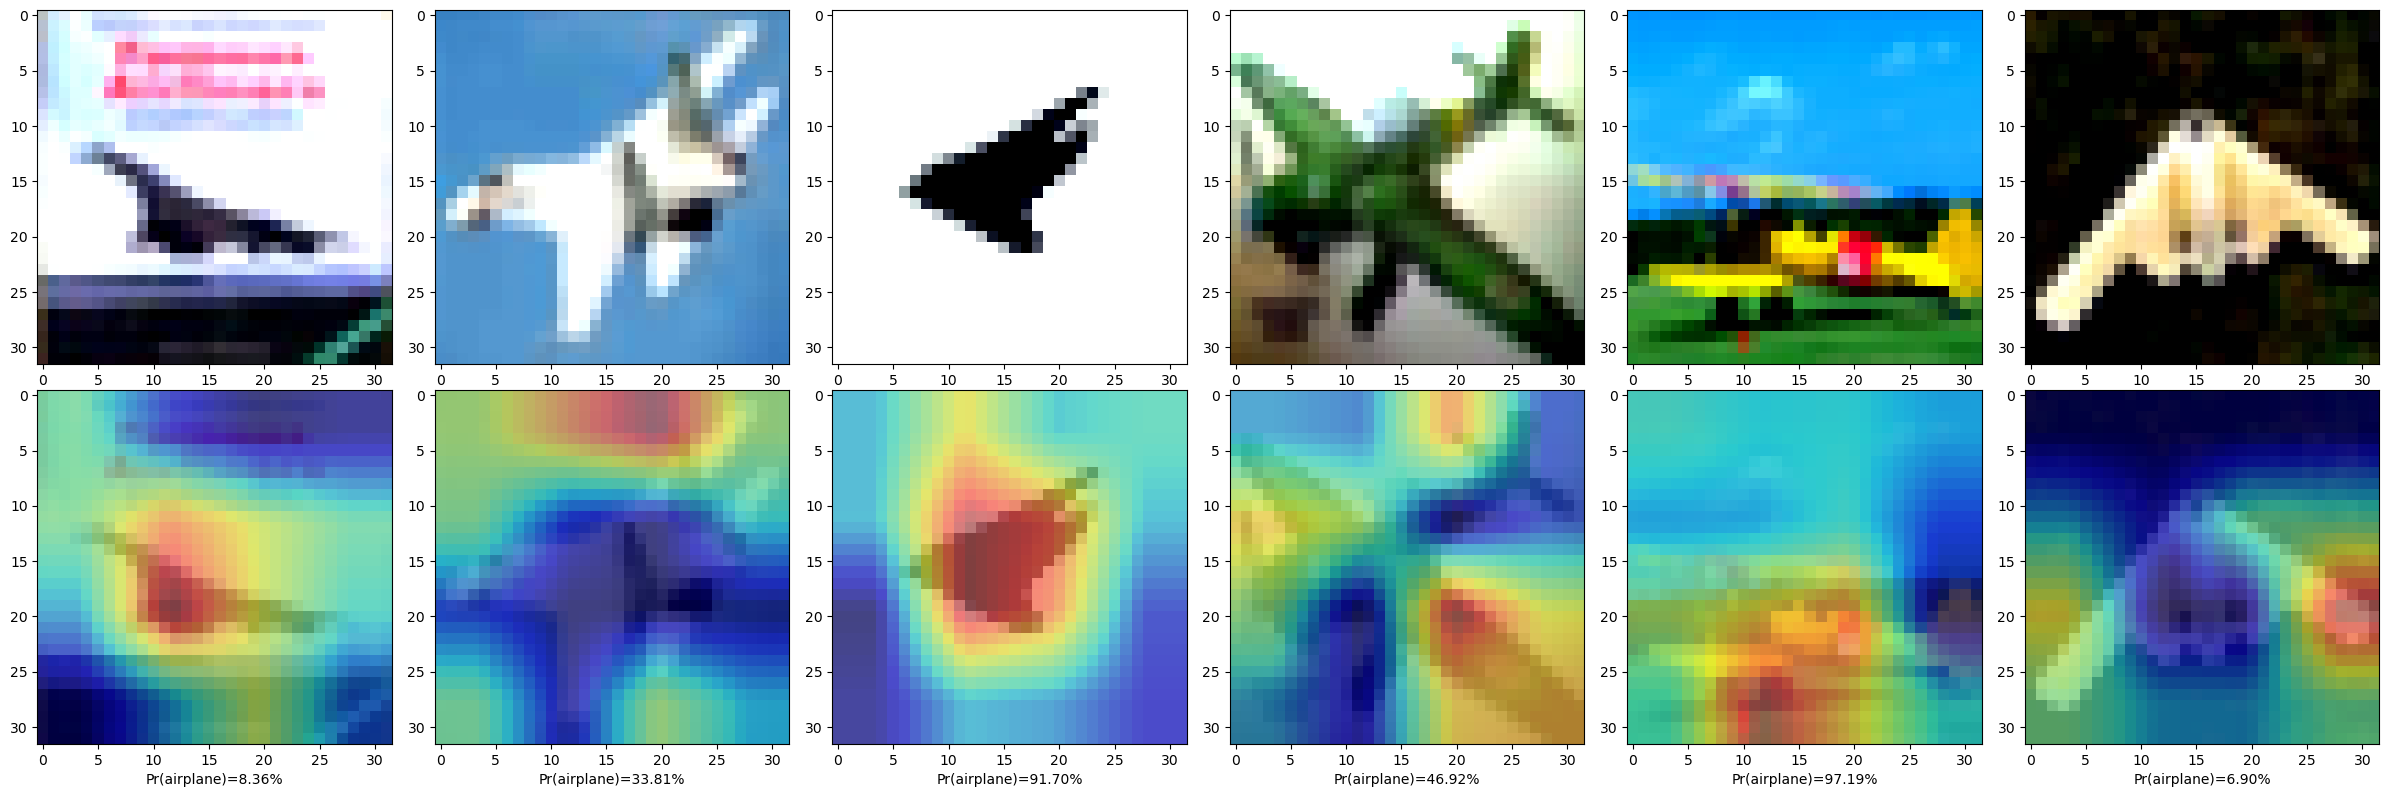

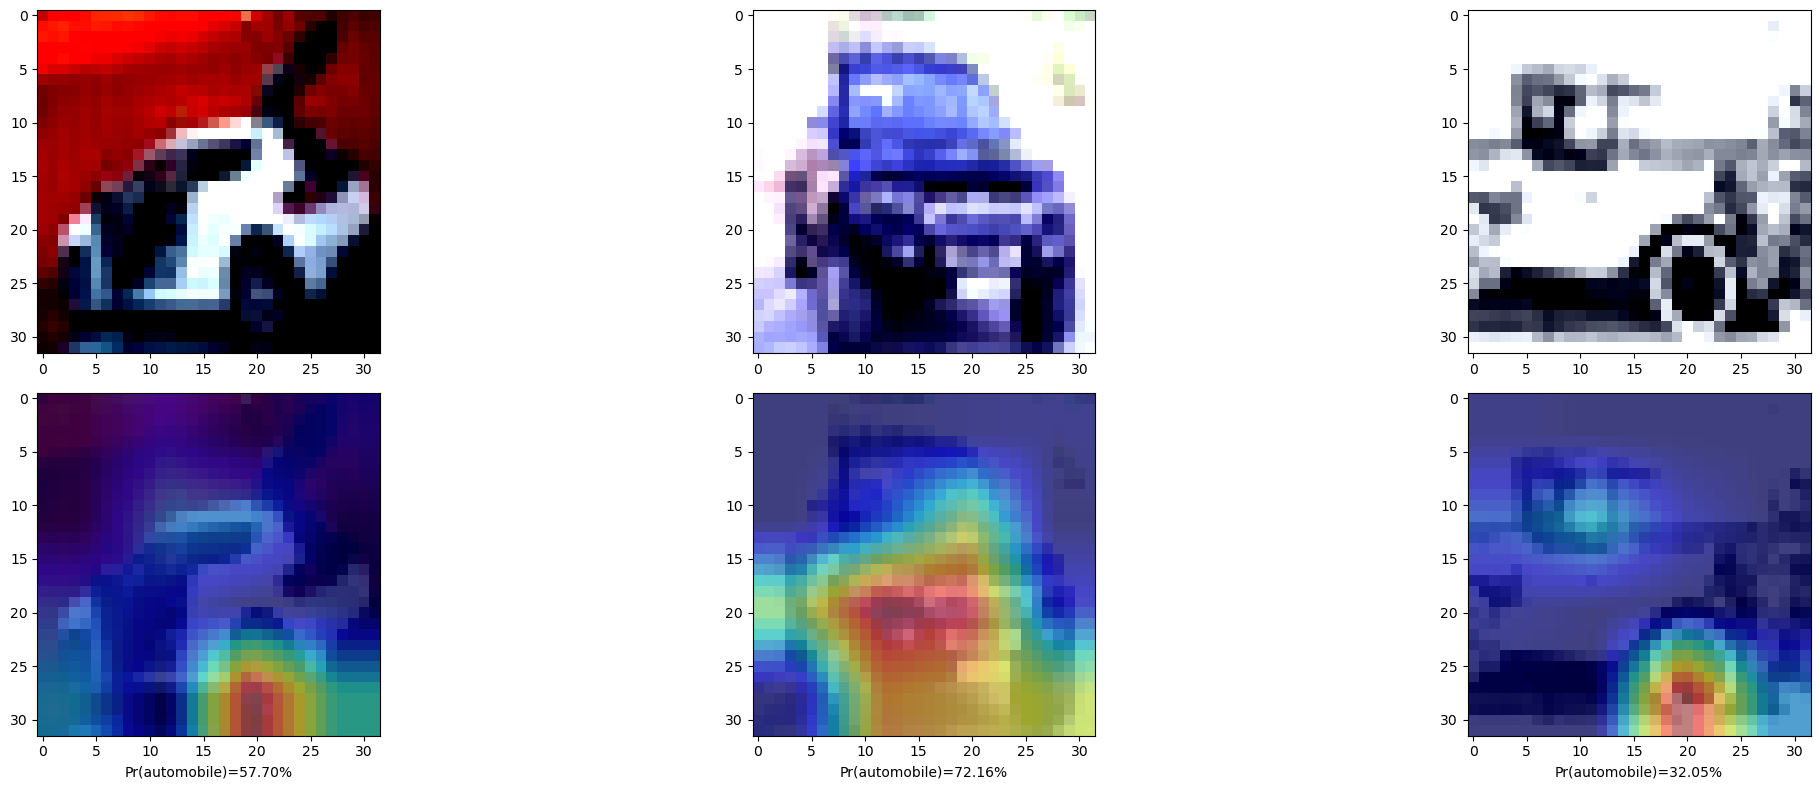

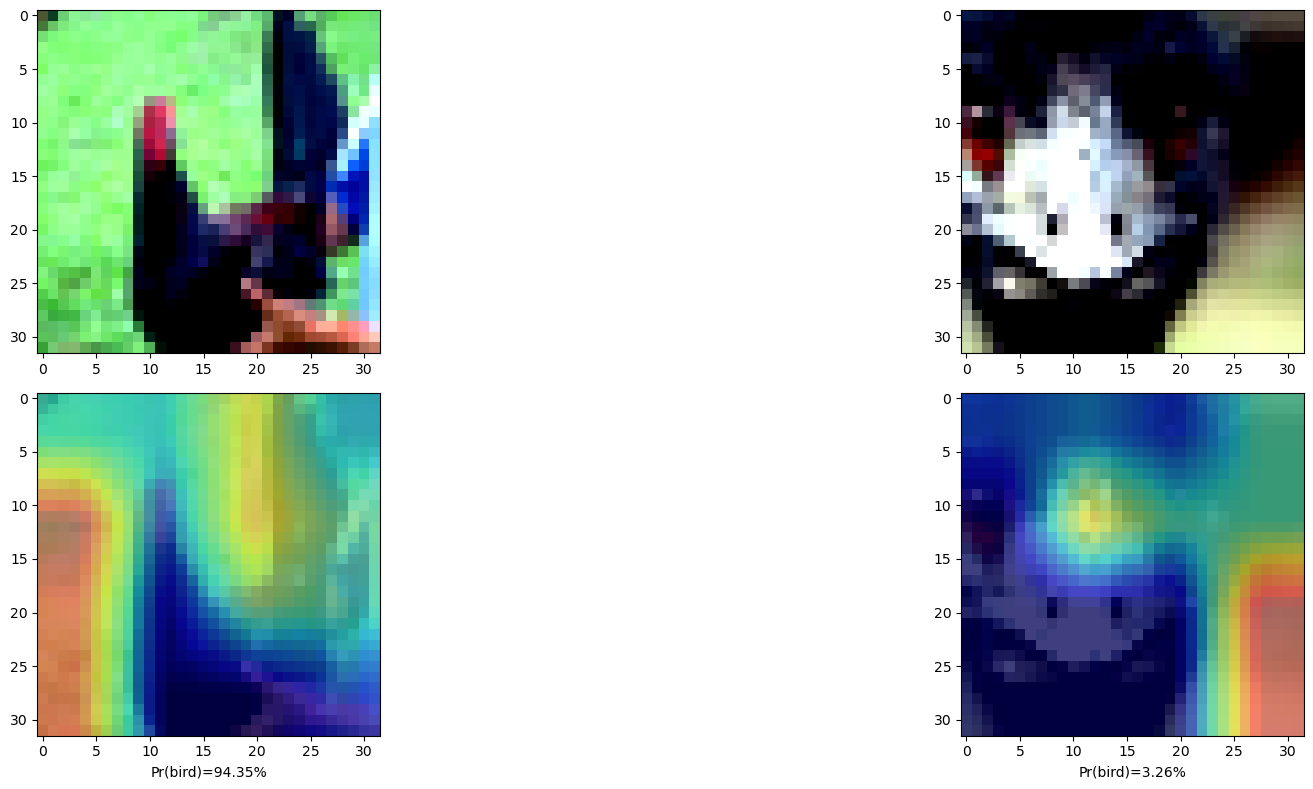

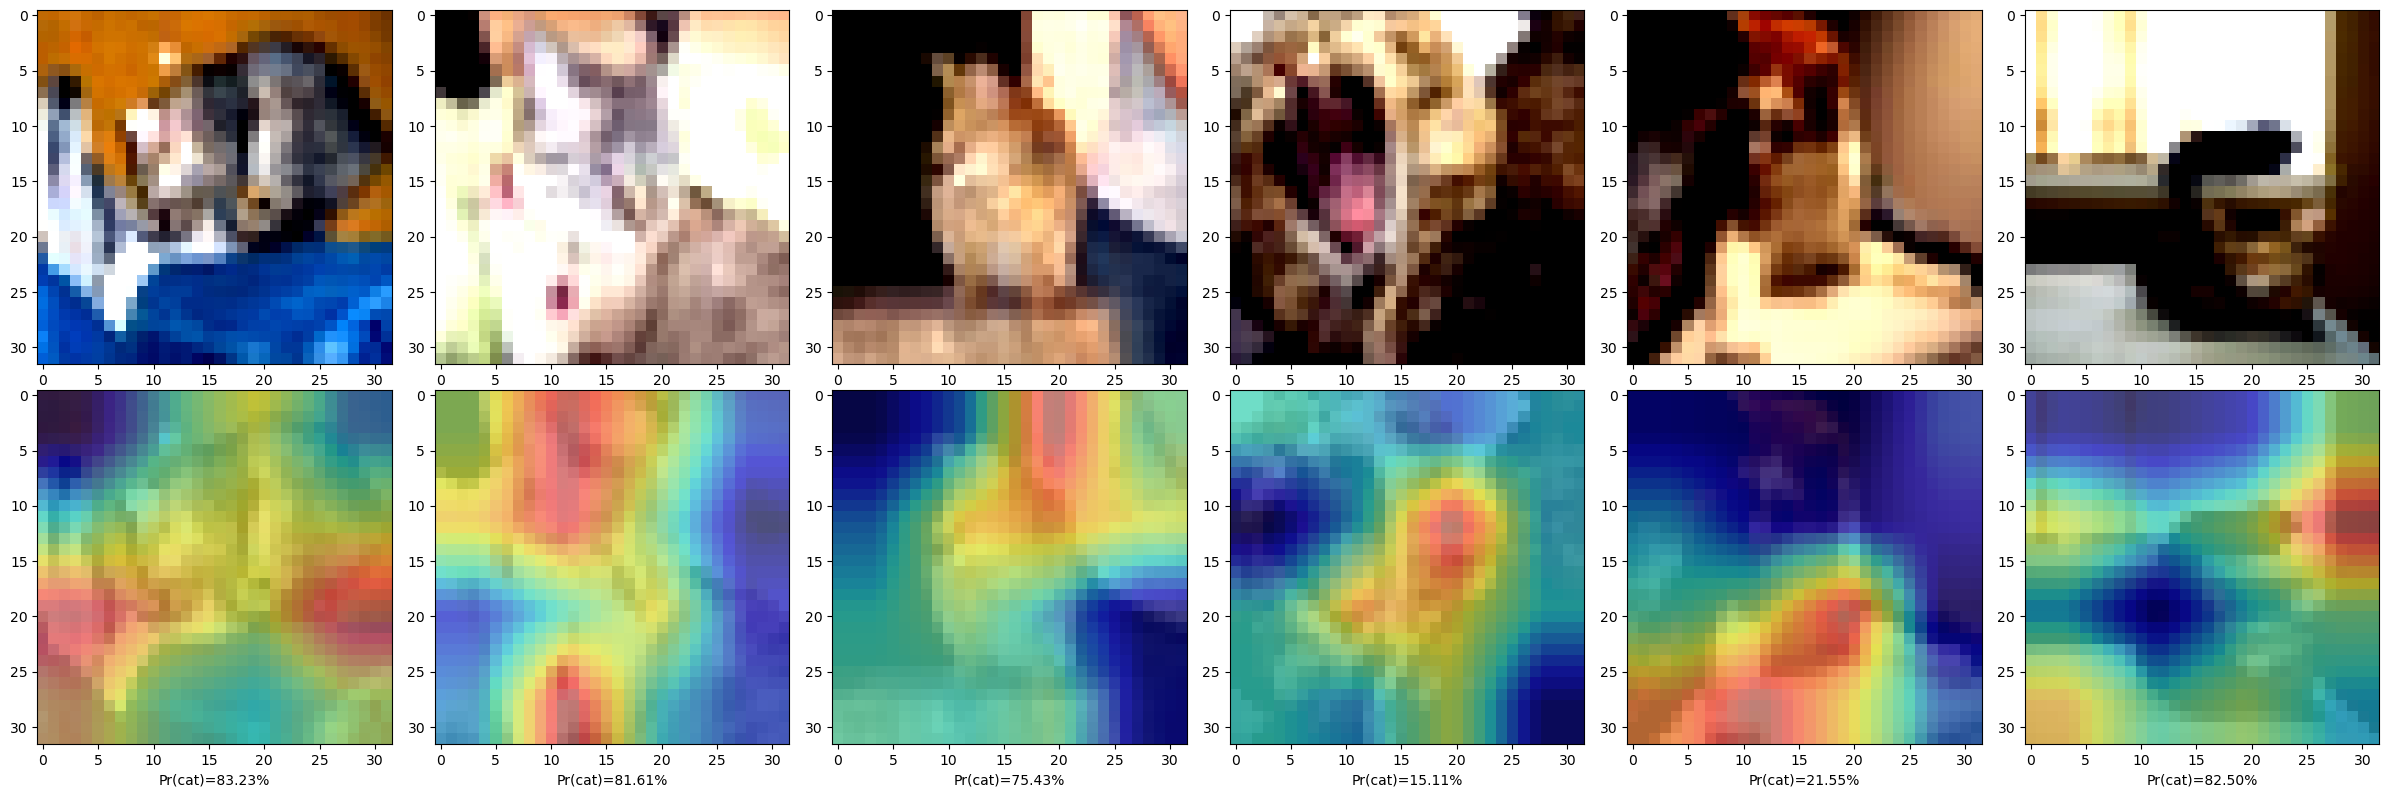

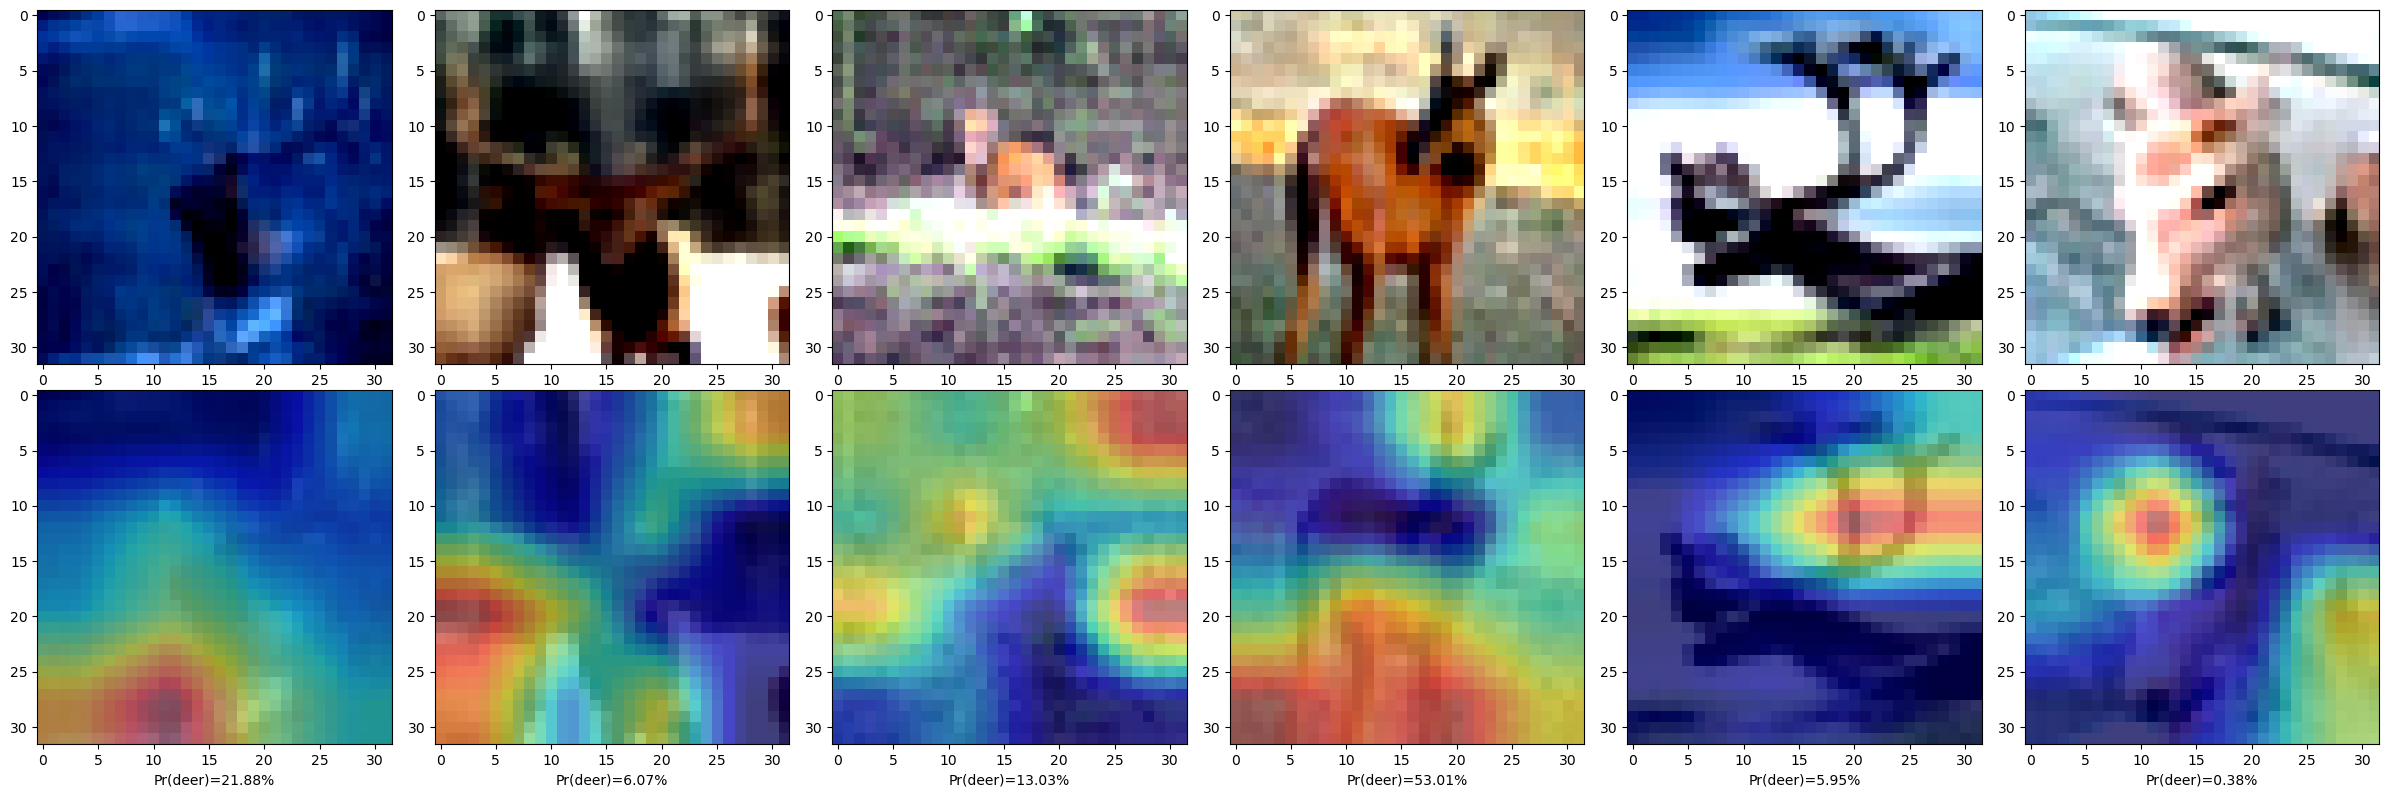

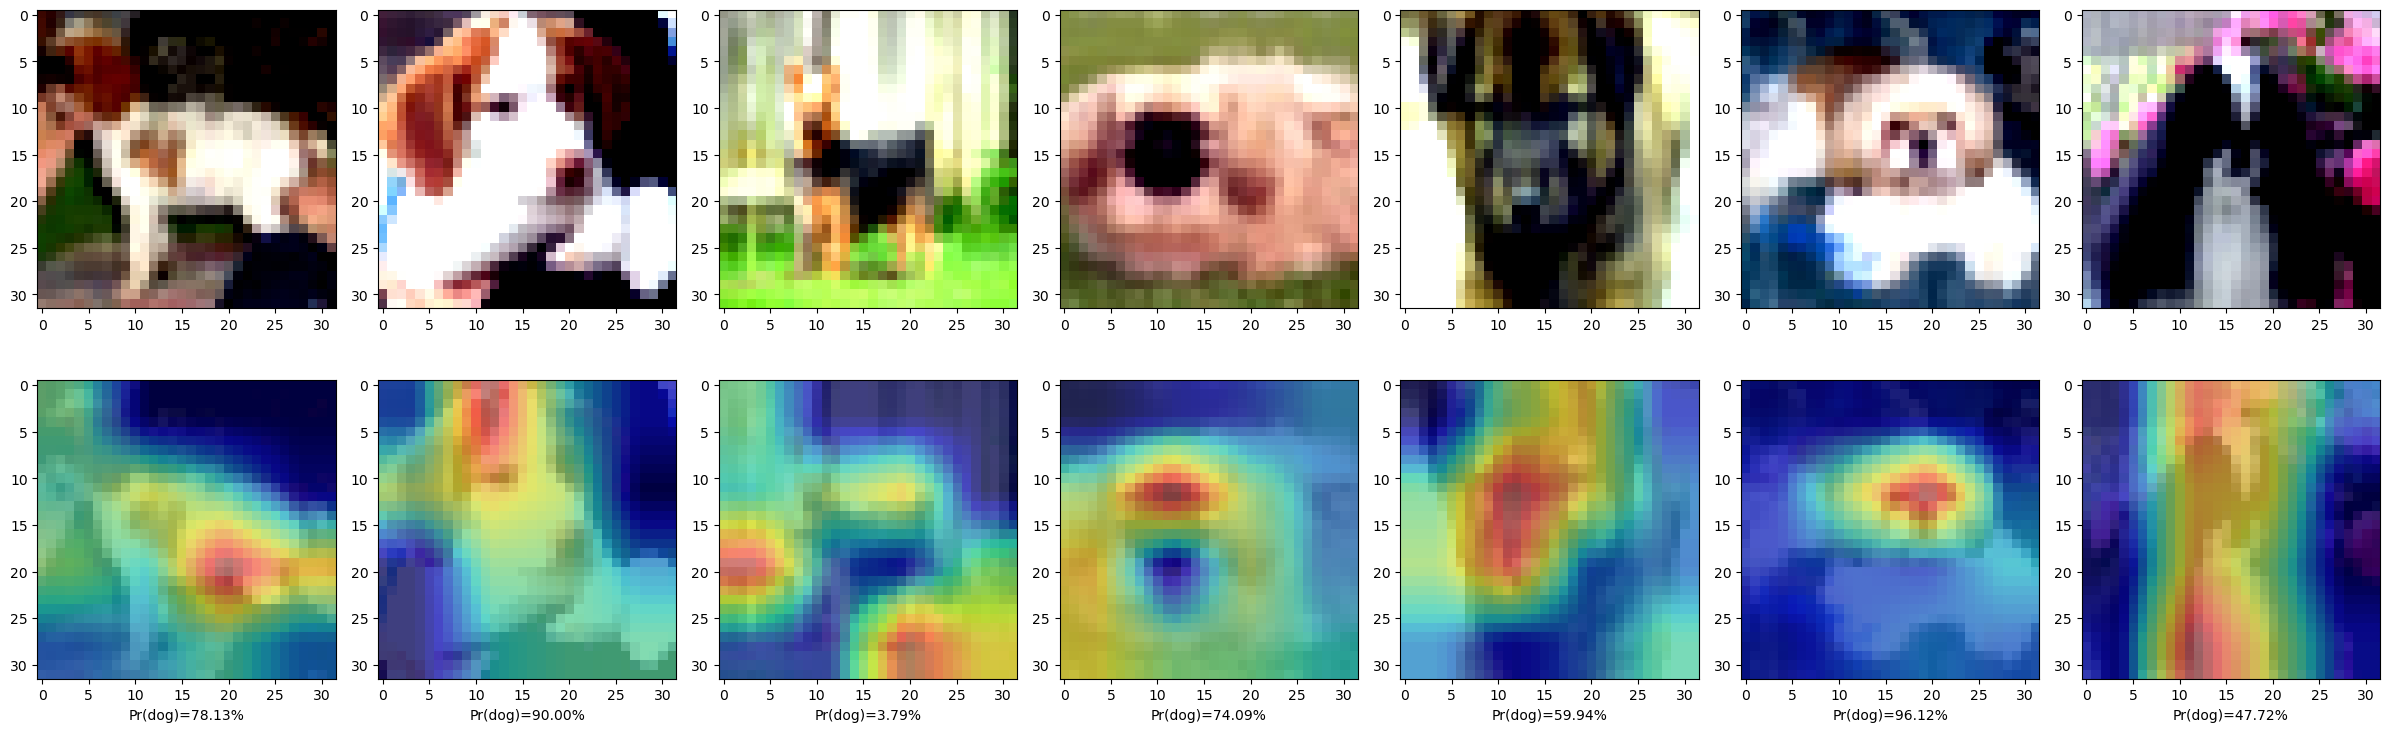

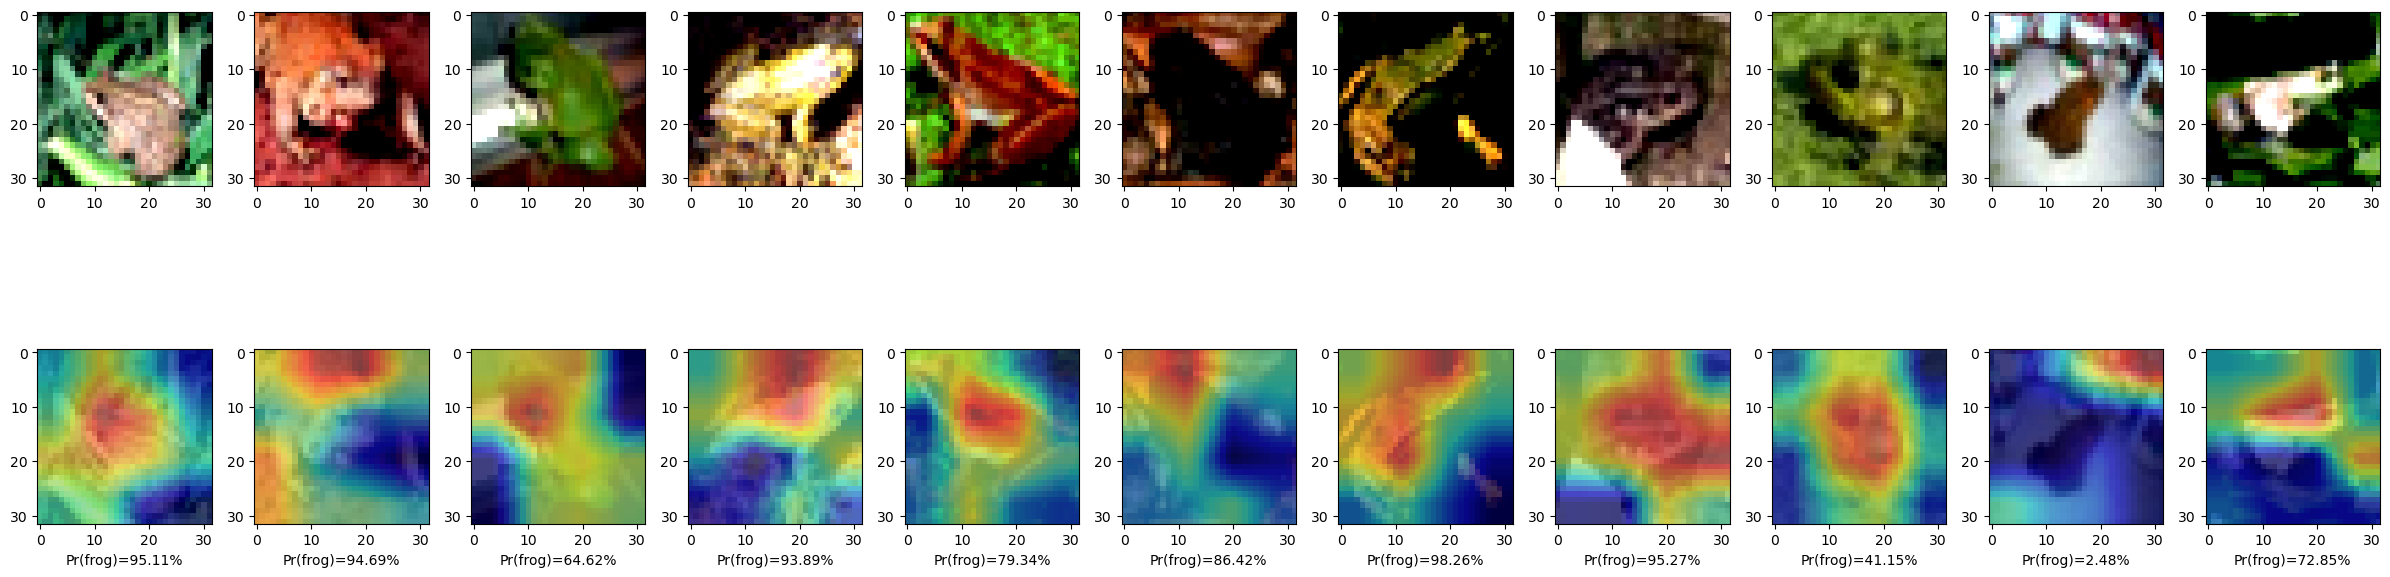

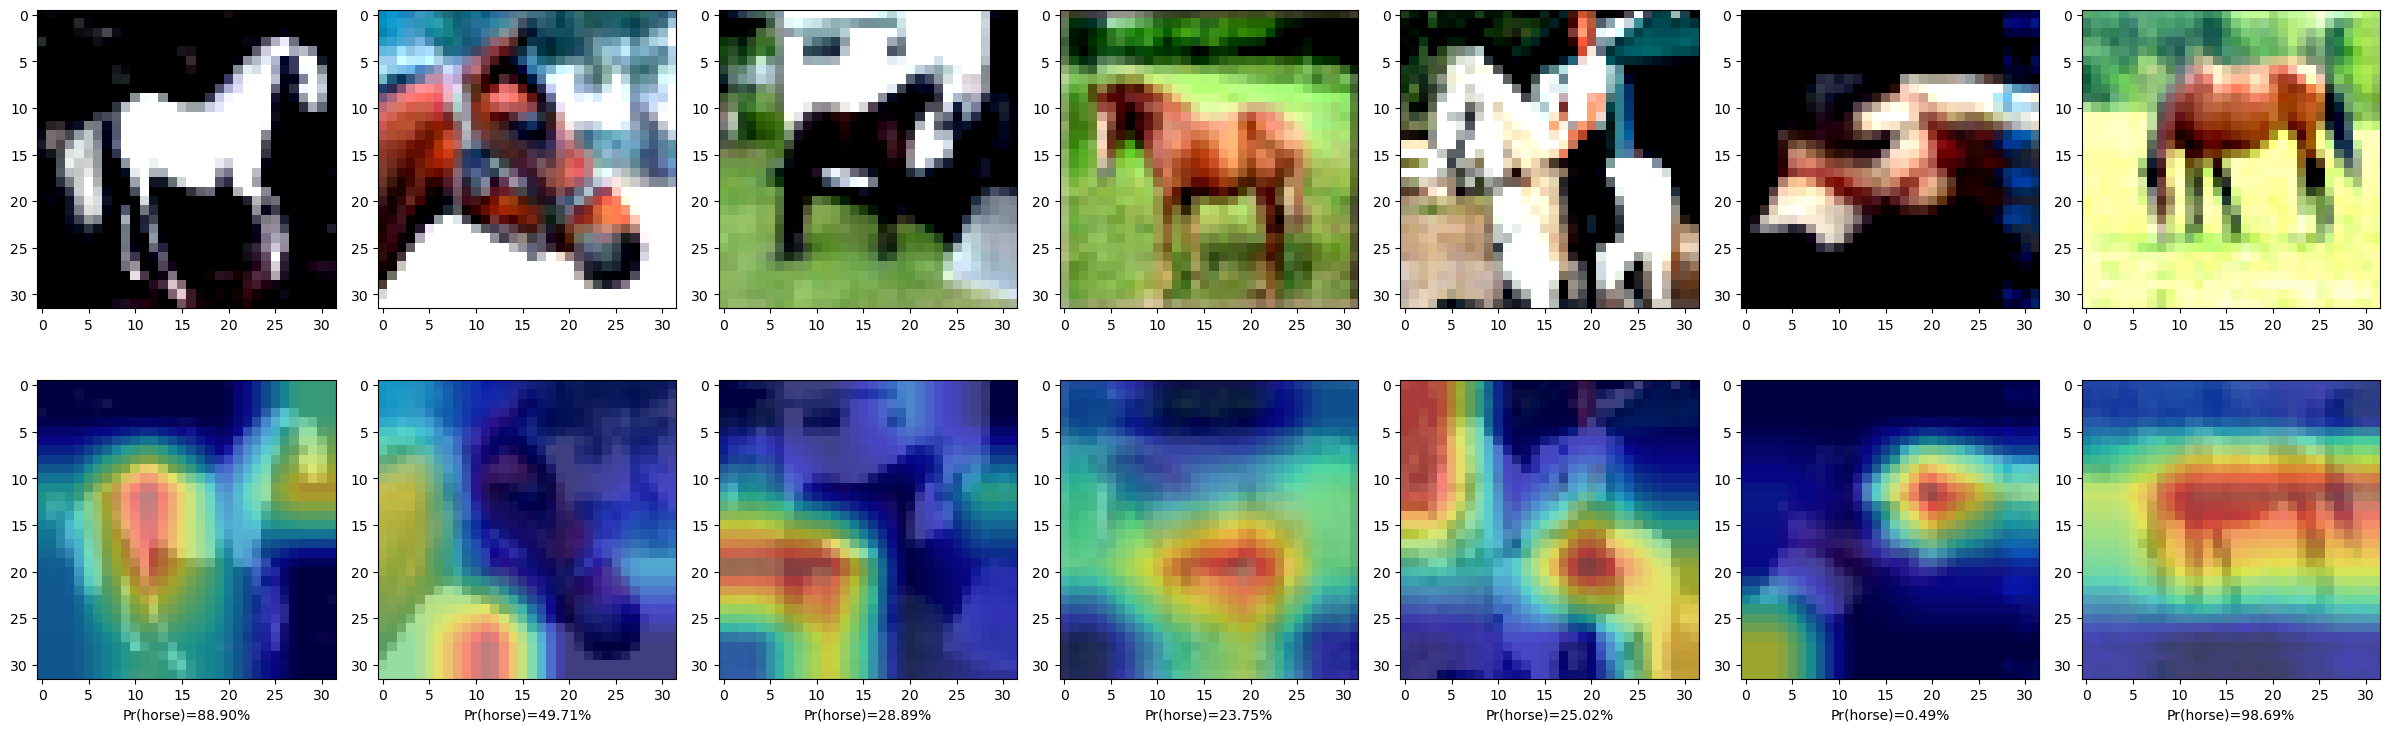

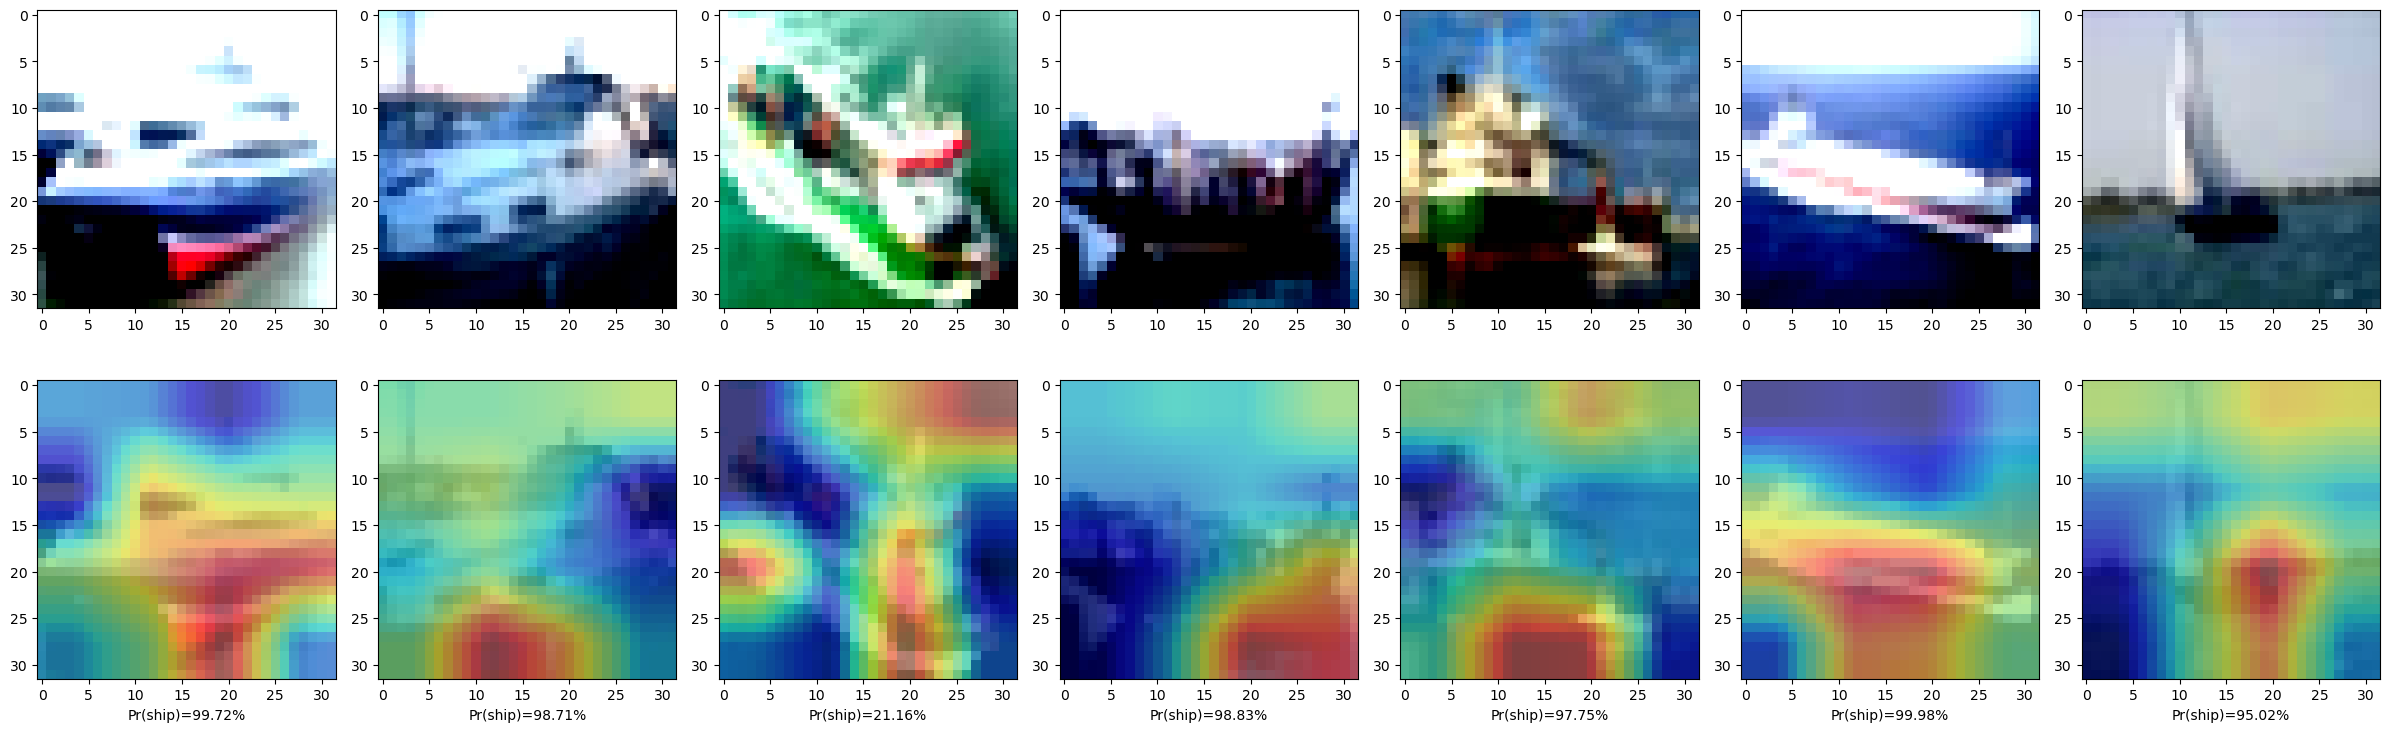

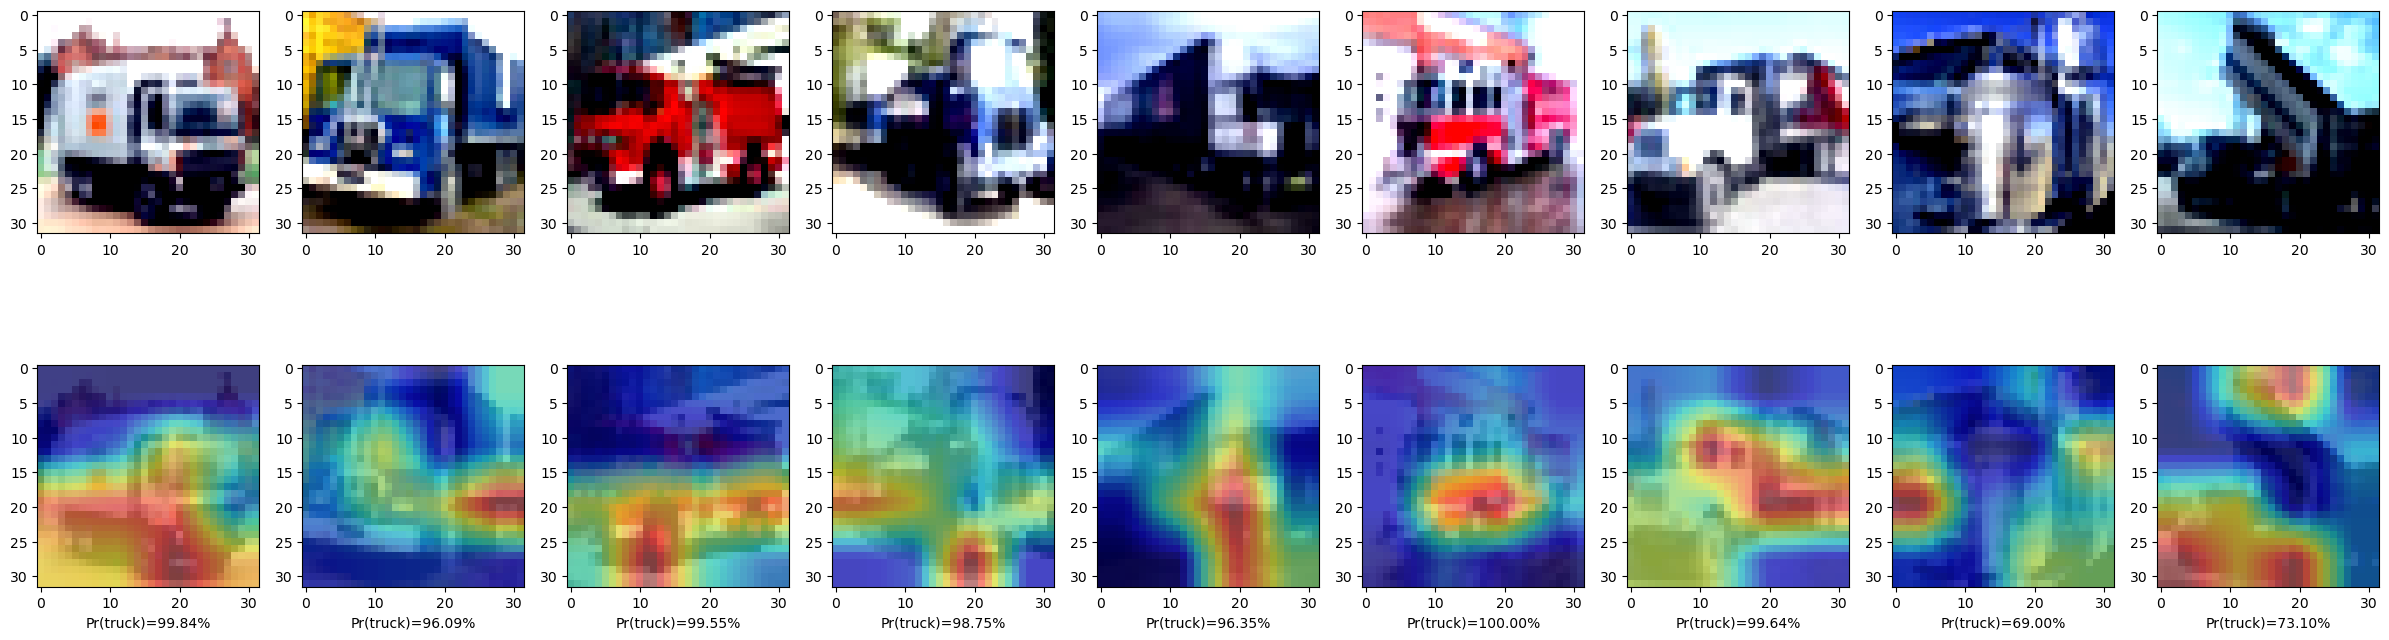

In [28]:
# plot CAM
model.load_state_dict(torch.load(path_models))
print(f'Model: {architecture["name"]}')
x, y = next(iter(dl_test))  # retrieve first batch of my dataloader
label_targets = torch.arange(0, dataset["num_classes"], 1).tolist()  # labels
for label_target in label_targets:
    imgs_by_label = []
    for img, label in zip(x, y):
        if label.item() == label_target:
            imgs_by_label.append(img)
    print(f"Img with target {label_target}: {len(imgs_by_label)}")

    imgs_by_label = torch.stack(imgs_by_label).to(device)

    plot_cam_with_images(
        model, imgs_by_label, class_target=label_target, n_img=len(imgs_by_label)
    )

per calcolare la CAM occorre:

- la classe target
- i pesi dell'ultimo layer collegati alla classe target
- la feature map in uscita dall'ultimo layer convoluzionale (in particolare il numero dei canali della feature map)


le architetture devono avere necessariamente un avarage pooling dopo gli strati convoluzionali
in pytorch puoi usare avarage pooling 2d specificando le dimensioni del kernel
altrimenti puoi usare Adaptive avarage pooling specificando che in uscita vuoi qualcosa di dimensioni 1x1
